In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# Geospatial Analysis
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree

# Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Statistical Modeling
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS


### Function dependendicies which are local

from Data_Cleaning_Merging.data_clean_merge import *
from Rain_analysis.rain_analysis import *
from Wind_analysis.wind_analysis import *


Processing file: bike_trips\202301-divvy-tripdata.csv
Creating station GeoDataFrame...
Missing start stations: 26721
Processing missing start stations...
Missing end stations: 27705
Processing missing end stations...
Station assignment complete!
Processing file: bike_trips\202302-divvy-tripdata.csv
Creating station GeoDataFrame...
Missing start stations: 25472
Processing missing start stations...
Missing end stations: 26621
Processing missing end stations...
Station assignment complete!
Processing file: bike_trips\202303-divvy-tripdata.csv
Creating station GeoDataFrame...
Missing start stations: 35910
Processing missing start stations...
Missing end stations: 38250
Processing missing end stations...
Station assignment complete!
Processing file: bike_trips\202304-divvy-tripdata.csv
Creating station GeoDataFrame...
Missing start stations: 63813
Processing missing start stations...
Missing end stations: 68184
Processing missing end stations...
Station assignment complete!
Processing file:

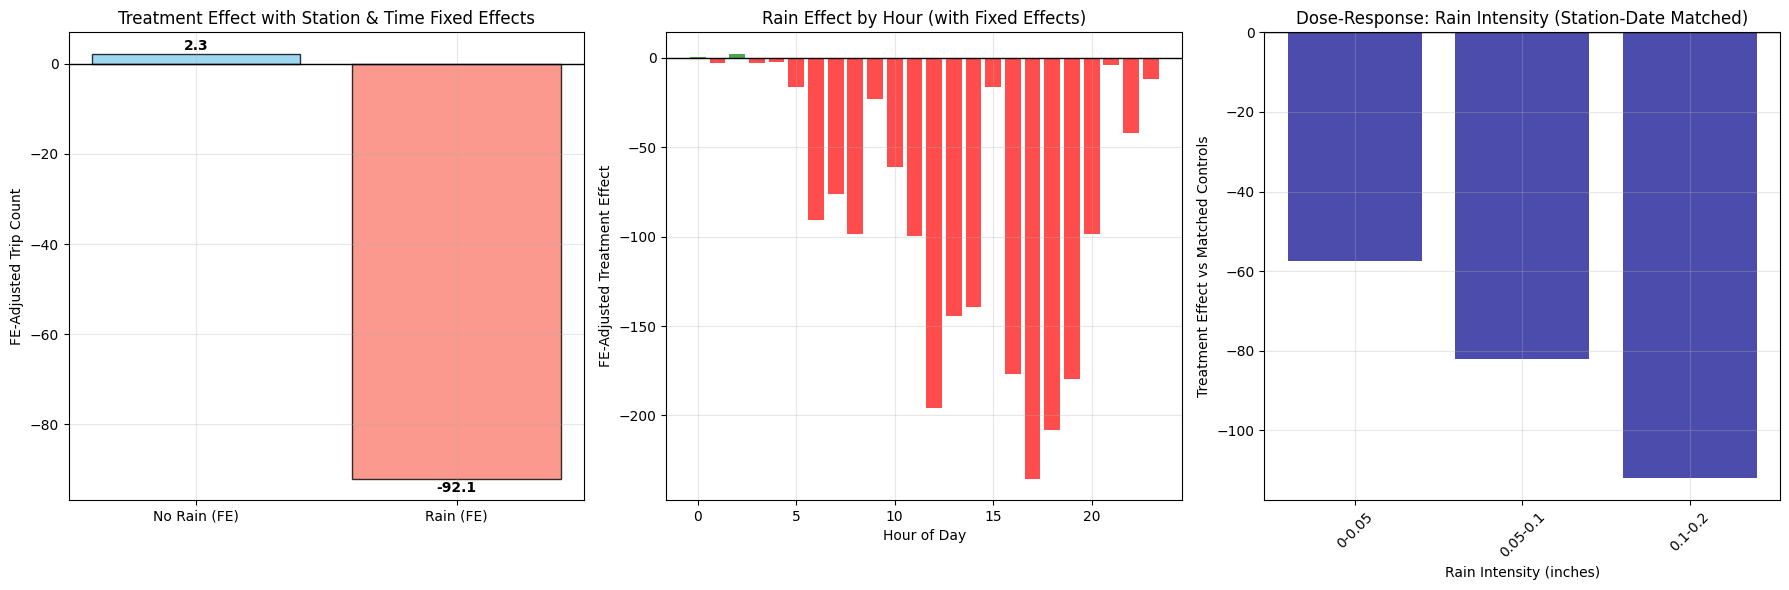

Analysis dataset shape: (4880194, 7)


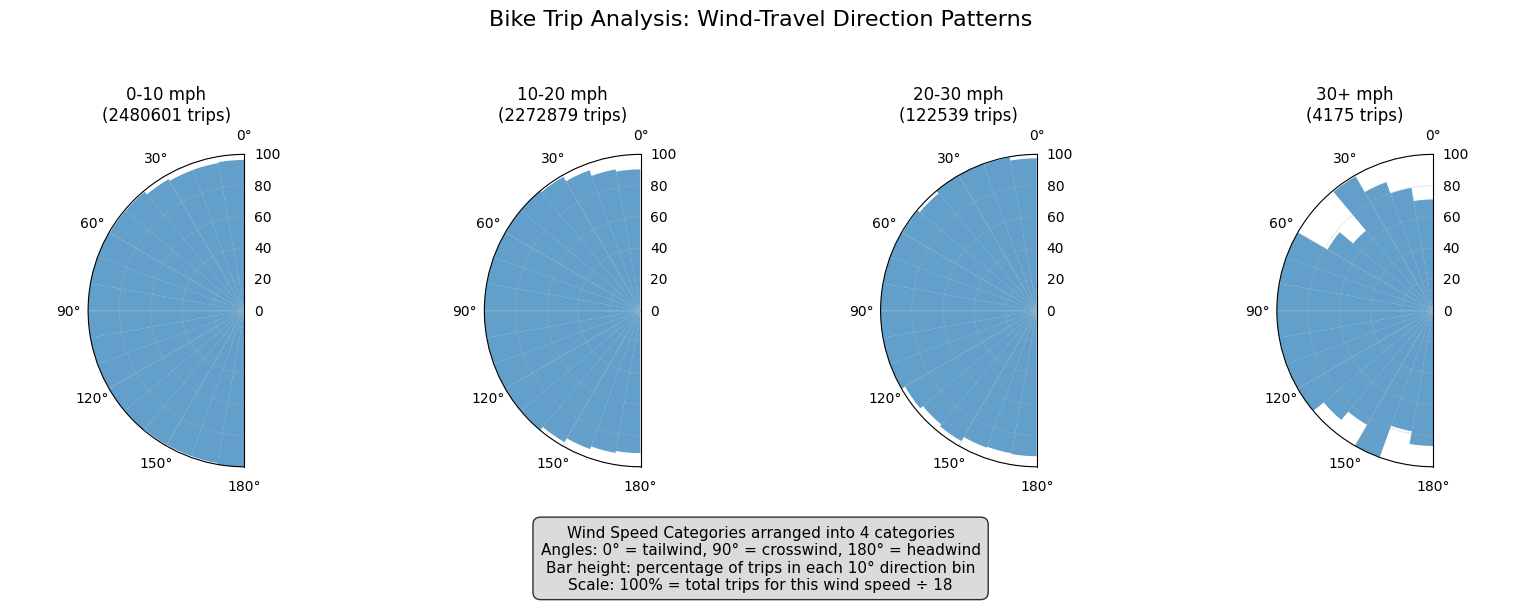

In [2]:
#################################
######READ BIKE DATA#################
############################

bike_df_full=concat_all_bikes_data('bike_trips', geo_analysis=True)  #With geographic station recovery

####################################
#######READ CLIMATE DATA###############
#####################################

climate_df_full=concat_climate_data('Climate_DATA_2023')

# Cleaning DATA
climate_df_full['HourlyPrecipitation'] = pd.to_numeric(climate_df_full['HourlyPrecipitation'], errors='coerce')
climate_df_full['HourlyDewPointTemperature'] = pd.to_numeric(climate_df_full['HourlyDewPointTemperature'], errors='coerce')
climate_df_full['HourlyWindDirection'] = pd.to_numeric(climate_df_full['HourlyWindDirection'], errors='coerce')
climate_df_full['HourlyWindSpeed'] = pd.to_numeric(climate_df_full['HourlyWindSpeed'], errors='coerce')


#MASK for subset where we have wind data
have_precipitation_mask=climate_df_full['NAME'].isin(climate_df_full.dropna(subset=['HourlyPrecipitation'])['NAME'].unique())

climate_df_full=climate_df_full[['DATE','LATITUDE','LONGITUDE','HourlyPrecipitation','HourlyDewPointTemperature','HourlyWindDirection','HourlyWindSpeed']]

climate_df_full=climate_df_full[have_precipitation_mask].reset_index(drop=True)
climate_df_full['HourlyPrecipitation']=climate_df_full['HourlyPrecipitation'].fillna(0)


##################################################################################################################
######Create heat-map of our trips starting points and Metereological stations, for understanding our sample######
##################################################################################################################


chicago_map = create_bike_heatmap(
        bike_df=bike_df_full,
        climate_df=climate_df_full,
        sample_fraction=0.1, # Using 10% of the data for this example
        output_filename="chicago_bike_heatmap_example2.html"
    )


#########################################################################################
#########Merge Climate and Bike data together by closest metereological station##########
#########################################################################################

trip_df, panel_data = merge_and_prepare_data(bike_df_full, climate_df_full)



###########################################################################################
#####################Analysis of Rain effect on Bike Trips#################################
###########################################################################################

analyze_rain_treatment_effect(
    panel_data,
    trip_col='trip_count',
    treatment_col='treated',
    intensity_col='rain_intensity',
    station_col='station_id',
    datetime_col='date_hour',
    show_plots=True
)


#########################################################################################
####################Analysis of Wind effect on Bike Trips################################
#########################################################################################

# Apply the function to to calculate distance and dirrection Bike trips into dataframe
trip_df = prepare_wind_analysis_dataset(
    trip_df, 
    min_distance=0.5, 
    max_distance=100,
    save_csv=False,
    csv_filename='my_trip_data.csv'
)

# Then create plots:
fig = create_wind_trip_plots(trip_df)